In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [2]:
df_jan = pd.read_parquet("../data/fhv_tripdata_2021-01.parquet")
df_feb = pd.read_parquet("../data/fhv_tripdata_2021-02.parquet")

### Q1. Downloading the data

Read the data for January. How many records are there?

In [3]:
df_jan.info()
len(df_jan)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 61.6+ MB


1154112

### Q2. Computing duration

What's the average trip duration in January?

In [4]:
duration = (df_jan.dropOff_datetime - df_jan.pickup_datetime)
duration.mean()

Timedelta('0 days 00:19:10.033445627')

### Data preparation

C:\Users\cami1\AppData\Local\Temp\ipykernel_3348\709918804.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_jan.append(df_feb)
c:\Users\cami1\.conda\envs\mlops_zoom\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

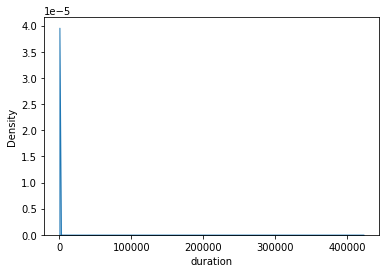

In [5]:
df = df_jan.append(df_feb)
df["duration"] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration.describe()
sns.distplot(df.duration, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1})


How many records did you drop?

In [6]:
MAX_TIME = 60
MIN_TIME = 1
df_clean = df[(df.duration <= MAX_TIME) & (df.duration >= MIN_TIME)]
df_clean.describe()
len(df) - len(df_clean)

91865

In [7]:
del df, df_clean

In [8]:
def df2min(df: pd.DataFrame) -> pd.DataFrame:
    df['duration'] = (df.dropOff_datetime - df.pickup_datetime)
    df['duration'] = df['duration'].dt.total_seconds()
    df['duration'] = df['duration']/60
    return df

def df_filter(df: pd.DataFrame, min: int = 1, max: int = 60) -> pd.DataFrame:
    return df[(df.duration >= min) & (df.duration <= max)]

def df_pipeline(df: pd.DataFrame, min: int = 1, max: int = 60) -> pd.DataFrame:
    df = df2min(df)
    df = df_filter(df, min, max)
    return df

In [9]:
df_jan_clean = df_pipeline(df_jan)
df_feb_clean = df_pipeline(df_feb)
(len(df_jan) - len(df_jan_clean))+(len(df_feb) - len(df_feb_clean))

91865

### Q3. Missing values

In [10]:
def missing_values(df: pd.DataFrame, cols: list = []) -> pd.DataFrame:
    d = {}
    for each in cols:
        df[each] = df[each].fillna(-1)
        nan_p = sum(df[each] == -1)/len(df)*100
        d[each] = nan_p
    return df, d

In [11]:
cols = ["PUlocationID", "DOlocationID"]
df_jan_clean, d_jan = missing_values(df_jan_clean, cols);
df_feb_clean, d_feb = missing_values(df_feb_clean, cols);


C:\Users\cami1\AppData\Local\Temp\ipykernel_3348\3234249418.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[each] = df[each].fillna(-1)


What's the fractions of missing values for the pickup location ID?

In [12]:
d_jan["PUlocationID"]

83.52732770722618

In [13]:
del df_jan, df_feb

### Q4. One-hot encoding

In [14]:
df_one_hot = pd.get_dummies(df_jan_clean[['PUlocationID', 'DOlocationID']], columns=["PUlocationID", "DOlocationID"])
df_one_hot.head()

,PUlocationID_-1.0,PUlocationID_1.0,PUlocationID_2.0,PUlocationID_3.0,PUlocationID_4.0,PUlocationID_5.0,PUlocationID_6.0,PUlocationID_7.0,PUlocationID_8.0,PUlocationID_9.0,...,DOlocationID_256.0,DOlocationID_257.0,DOlocationID_258.0,DOlocationID_259.0,DOlocationID_260.0,DOlocationID_261.0,DOlocationID_262.0,DOlocationID_263.0,DOlocationID_264.0,DOlocationID_265.0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



What's the dimensionality of this matrix? 

In [15]:
np.shape(df_one_hot)[1]

525

In [16]:
dv = DictVectorizer()

train_dicts = df_jan_clean.drop(columns=["duration", "pickup_datetime", "dropOff_datetime", "SR_Flag", "Affiliated_base_number", "dispatching_base_num"]).to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts  = df_feb_clean.drop(columns=["duration", "pickup_datetime", "dropOff_datetime", "SR_Flag", "Affiliated_base_number", "dispatching_base_num"]).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [17]:
target = 'duration'
y_train = df_jan_clean[target].values
y_val = df_feb_clean[target].values

### Q5. Training a model

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

What's the RMSE on train?

In [19]:
y_pred = lr.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

11.415432830521663

### Q6. Evaluating the model

In [20]:
y_pred = lr.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

11.858223623559352